In [1]:
import numpy as np
import datetime
import os
import random, shutil
import glob
import skillsnetwork

import warnings
warnings.simplefilter('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics


sns.set_context('notebook')
sns.set_style('white')

2.16.1


### What is transfer learning?
Most popular models are difficult to train from scratch as they require huge datasets (like ImageNet), a large number of training iterations, and very heavy computing machinery. The basic features (edges, shapes) learned by early layers in a network are generalizable. While the later layers in an already trained network tend to capture features that are more particular to a specific image classification task. 

__Transfer learning__ uses the idea that if we keep the early layers of a pre-trained network, and re-train the later layers on a specific dataset, we might be able to leverage some state of that network on a related task.

A typical transfer learning workflow in Keras looks something like this:
    
1. Initialize base model, and load pre-trained weights (like ImageNet).
2. "Freeze" layers in the base model by setting `training = False`.
3. Define a new model that goes on top of the output of the base model's layers.
4. Train resulting model on your data set.


## Example 1: Create a ML model for distinguishing recyclable and organic waste images



### Dataset
The dataset used in this Lab was found on Kaggle, which is an awesome community for people who enjoy anything related to data science and machine learning. We will be using the Waste Classification Dataset [dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01):

> PROBLEM: 
> - Waste management is a big problem in our country. Most of the wastes end up in landfills.

> APPROACH: 
> - Segregated into two classes (Organic and recyclable)
> - Automated the process by using IOT and machine learning

> IMPLEMENTATION:
> - Dataset is divided into train data (85%) and test data (15%)
> - Training data - 22,564 images Test data - 2,513 images


* The dataset contains ~25,000 images of recyclable and organic products split into a train and test set.
* Our goal is to train an algorithm on these files and to predict the labels for images in our test set (1 = recyclable, 0 = organic).

Now that we have obtained the necessary context and some insight in today's dataset, we're moving on to the practical part: using transfer learning to classify images. In this task, we will be using Tensorflow, which is a highly used ML library for training neural networks, and Keras, which is an API that makes this process simpler.

We will go through the following steps to create our classification model:

1. Import data directly from Kaggle.
2. Visualize a few random images from the train set.
3. Load images in using the ImageGeneratorClass from Keras.
4. Define model configuration options.
5. Perform some image augmentation for improved model generalizability.
6. Load, compile and train a pre-trained model like VGG-16.
7. Perform inference on the test set. 


In [2]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = './dataset/Waste Classification data/DATASET/TRAIN'
path_test = './dataset/Waste Classification data/DATASET/TEST'
input_shape = (img_rows, img_cols, 3) #RGB
labels = ['O', 'R']
seed = 10
checkpoint_path='ORnet.h5'

In [3]:
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

Found 18052 images belonging to 2 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

Found 4512 images belonging to 2 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = labels,
    class_mode='binary',
    seed = seed,
    batch_size = batch_size, 
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 2513 images belonging to 2 classes.


Labels: ['DATASET', 'DATASET', 'DATASET', 'DATASET', 'DATASET']


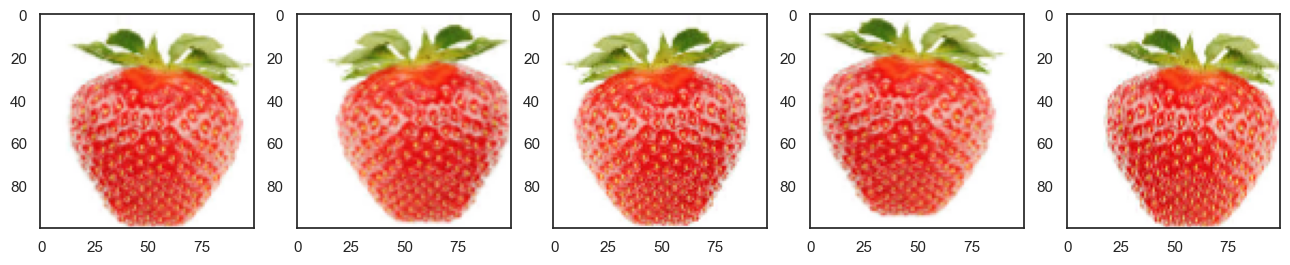

In [7]:
IMG_DIM = (100, 100)

train_files = glob.glob('./dataset/Waste Classification data/DATASET/TRAIN/O/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


### Pre-trained Models

Pre-trained models are saved networks that have previously been trained on some large (somewhat related) datasets. They are typically used for a large-scale image-classification task. They can be used as they are or could be customized to a given task using transfer learning. These pre-trained models form the basis of transfer learning.

We can leverage a pre-trained model's weighted layers to extract generic features. In this step we would not update the model's layers weights during training. This helps us utilize the knowledge from a source-domain task.

Fine-tuning, which is a more involved process, involves more than just replacing the final layer. We also try to retrain some of the previous layers.
In computer vision, some popular pre-trained models include: VGG-16, VGG-19, InceptionV3, XCeption, and ResNet-50.


In [8]:
from keras.applications import vgg16

In [10]:
from keras.applications import vgg16
input_shape = (150, 150, 3)

vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



In [11]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [13]:
basemodel.trainable = False
for layer in basemodel.layers: layer.trainable = False

Create a new model on top. We add a Dropout layer for regularization, only these layers will change as for the lower layers we set `training=False` when calling the base model.


In [14]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])


We use early stopping to avoid over-training the model. An over-trained model overfits the training dataset and has poor performance on unseen test sets. We will also use a exponential step-decay based learning rate scheduler.


In [18]:
checkpoint_path = 'O_R_tlearn_image_augm_cnn_vgg16.keras'

# # Define step decay function
# class LossHistory_(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []
#         self.lr = []
        
#     def on_epoch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))
#         self.lr.append(exp_decay(len(self.losses)))
#         print('lr:', exp_decay(len(self.losses)))  # Corrected print statement

# def exp_decay(epoch):
#     initial_lrate = 0.1
#     k = 0.1
#     lrate = initial_lrate * np.exp(-k*epoch)
#     return lrate

# # Learning schedule callback
# loss_history_ = LossHistory_()
# lrate_ = LearningRateScheduler(exp_decay)

# keras_callbacks = [
#     EarlyStopping(monitor='loss', 
#                   patience=5, 
#                   mode='min', 
#                   min_delta=0.01),
#     ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
# ]

# callbacks_list_ = [loss_history_, lrate_, keras_callbacks]
from keras.callbacks import LearningRateScheduler
# checkpoint_path='O_R_tlearn_image_augm_cnn_vgg16.h5'

# define step decay function
class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

In [19]:
extract_feat_model = model.fit(train_generator, 
                              steps_per_epoch=10, 
                              epochs=5,
                              validation_data=val_generator, 
                              validation_steps=10, 
                              verbose=1,
                              callbacks = callbacks_list_)  

Epoch 1/5
 5/10 ━━━━━━━━━━━━━━━━━━━━ 1:50 22s/step - accuracy: 0.4422 - loss: 67969.5781

In [36]:
[layer.name for layer in basemodel.layers]

['input_layer',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten']

In [37]:
basemodel.trainable = True
set_trainable = True
for layer in basemodel.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [38]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [41]:
checkpoint_path='O_R_tlearn_image_augm_fine_tune_vgg16.keras'
# checkpoint_path = 'O_R_tlearn_image_augm_cnn_vgg16.keras'


# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])
              
fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=10, 
                    epochs=5,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=10, 
                    verbose=1)       

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.4738 - loss: 376644881446647055796012056576.0000 lr: 0.09048374180359596
10/10 ━━━━━━━━━━━━━━━━━━━━ 675s 68s/step - accuracy: 0.4756 - loss: 375885902705520246417266835456.0000 - val_accuracy: 0.5875 - val_loss: 270683232267664273340507357184.0000 - learning_rate: 0.1000
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.5214 - loss: 354398719640212868166171230208.0000 lr: 0.0818730753077982
10/10 ━━━━━━━━━━━━━━━━━━━━ 592s 61s/step - accuracy: 0.5220 - loss: 355392532221799819262103126016.0000 - val_accuracy: 0.6000 - val_loss: 263471120838230162298665697280.0000 - learning_rate: 0.0905
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.5914 - loss: 306762263312515814601791635456.0000 lr: 0.0740818220681718
10/10 ━━━━━━━━━━━━━━━━━━━━ 589s 60s/step - accuracy: 0.5891 - loss: 308226858053513006368367312896.0000 - val_accuracy: 0.5813 - val_loss: 280731068101663811897430900736.0000 - learning_rate: 0.08

### Evaluate both models on test data


In [52]:
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_image_augm_cnn_vgg16.keras')
# fine_tune_model = tf.keras.models.load_model('O_R_tlearn_image_augm_fine_tune_vgg16.keras')

ValueError: Input 0 of layer "dense_4" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (512,)

In [47]:
from sklearn.utils import shuffle


IMG_DIM = (150, 150)

# Read in all O and R test images file paths. Shuffle and select 50 random test images. 
test_files_O = glob.glob('.//dataset/Waste Classification data/DATASET/TESTO/O/*')
test_files_R = glob.glob('./dataset/Waste Classification data/DATASET/TEST/R/*')
test_files = test_files_O + test_files_R
test_files = shuffle(test_files)[0:50]

# Extract label from file path
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[3].split('.')[0].strip() for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [48]:
class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

In [49]:
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

AttributeError: 'History' object has no attribute 'predict'

In [ ]:
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

In [ ]:
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

In [ ]:
custom_im = test_imgs_scaled[2]
plt.imshow(custom_im)

num2class_lt(extract_feat_model.predict(custom_im.reshape((1,
                                                           test_imgs_scaled.shape[1], 
                                                           test_imgs_scaled.shape[2], 
                                                           test_imgs_scaled.shape[3])), verbose=0))

In [ ]:
custom_im = test_imgs_scaled[3]
plt.imshow(custom_im)

num2class_lt(extract_feat_model.predict(custom_im.reshape((1,
                                                           test_imgs_scaled.shape[1], 
                                                           test_imgs_scaled.shape[2], 
                                                           test_imgs_scaled.shape[3])), verbose=0))

## Example 2: Use Transfer Learning for identifying Stop Signs

Other than VGG-16, there are many state-of-the-art CNN architectures we could explore, such as **InceptionNet, MobileNet, ResNet, Xception**, and so on. There are more than two dozen pre-trained models available from Keras that we could use directly for transfer learning. In this example, we will implement some of them for distinguishing stop signs. 

The stop sign datasets will be downloaded using the following cells. Compared to a typical dataset of images, the stop sign dataset is relatively small as it only contains around 200 training images and 8 test images. This is when transfer learning should come to rescue, because training models from scratch would require a lot of data, otherwise you will likely overfit your model. 


In [53]:
dataset_home = 'signs/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['stop/', 'not_stop/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok = True)

In [59]:
for file in listdir("./dataset/stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"stop/{file}", f"signs/train/stop/{file}")
        
for file in listdir("not_stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"not_stop/{file}", f"signs/train/not_stop/{file}")

test_path = "test_set_stop_not_stop/"
for file in listdir(test_path):
    if file.startswith("stop"):
        shutil.copyfile(test_path+file, f"signs/test/stop/{file}")
    elif file.startswith("not_stop"):
        shutil.copyfile(test_path+file, f"signs/test/not_stop/{file}")      
       

PermissionError: [Errno 13] Permission denied: './dataset/stop'